<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.3.1'

In [4]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [5]:
import tensorflow_datasets as tfds

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [7]:
# ! pip install tensorflow-probability==0.11.0
# ! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

In [8]:
import tensorflow_probability as tfp

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D
from tensorflow.keras.layers import RepeatVector, Conv2DTranspose, Flatten
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking, Dropout
import tensorflow.keras.backend as K

In [10]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='valid', output_padding=0, name=None):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, output_padding=(output_padding,0), name=name)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

#### load some SDSS data


In [11]:
import sdss_pae.sdss_dataset as sdss 

In [187]:
ds, info = tfds.load('SDSS', data_dir='/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_data_large',with_info=True, split='train')

In [188]:
info

tfds.core.DatasetInfo(
    name='sdss',
    version=1.0.0,
    description='selected features from spAll and spZbest files 
'flux': measured spectrum in  
'inv_var': inverse variance
'and_mask': and mask (set to 1 for all non-zero entries)
'coeffs': c0, c1, npix. calculate wavelengths with `10.**(c0 + c1 * np.arange(npix))`
'label': type of object, 'STAR'==0, 'QSO'==1, 'GALAXY'==2
'redshift': object redshift estimate',
    homepage='https://www.sdss.org/science/data-release-publications/',
    features=FeaturesDict({
        'and_mask': Tensor(shape=(None, 1), dtype=tf.int32),
        'coeffs': Tensor(shape=(3, 1), dtype=tf.float32),
        'filename': Text(shape=(), dtype=tf.string),
        'flux': Tensor(shape=(None, 1), dtype=tf.float32),
        'inv_var': Tensor(shape=(None, 1), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
        'redshift': tf.float32,
    }),
    total_num_examples=200000,
    splits={
        'train': 200000,
    }

In [189]:
# use only galxies for now
select_by   = 2
# de-redhsift or not?
de_redshift = True

In [190]:
z_ref  = 0.1
ld_ref = cosmo.luminosity_distance(z_ref)

In [191]:
# filter dataset by redshifts and type

def filter_type_fn(x):
    if select_by is not None:
        return tf.math.equal(x['label'], select_by)
    else: return 1
    
def filter_redshift_fn(x):
    if select_by is not None:
        return tf.math.logical_and(tf.math.greater(x['redshift'], 0.2),tf.math.less(x['redshift'], 1.0))
    else: return 1

ds = ds.filter(filter_type_fn)
ds = ds.filter(filter_redshift_fn)

In [192]:
DATASET_SIZE=len(list(ds))

In [193]:
print('size of subselected data:', DATASET_SIZE)

size of subselected data: 103645


In [194]:
# computing maximum and minimum redhsift in the data sample, getting distribution of data sizes
# this doe not need to be run every time - especially if wavelength range is set by user

ii          = 0
min_wl      = 100
max_wl      = -100
num_npixs   = []
img_coeffs1 = []
img_coeffs2 = []
factors     = []
min_z       = 5
max_z       = -5
redshifts   = []

for image in tfds.as_numpy(ds):
    log10wl = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
    if de_redshift:
        log10wl = log10wl-np.log10(1+image['redshift'])
    if max(log10wl)>max_wl:
        max_wl= max(log10wl)
    if min(log10wl)<min_wl:
        min_wl=min(log10wl)
    redshifts.append(image['redshift'])
#     if image['redshift']>max_z:
#         max_z = image['redshift']
#     if image['redshift']<min_z:
#         min_z = image['redshift']
#     if image['coeffs'][2] not in num_npixs:
#         num_npixs.append(image['coeffs'][2][0])
#         img_coeffs1.append(image['coeffs'][1][0])
#     if image['coeffs'][0] not in img_coeffs2:
#         img_coeffs2.append(image['coeffs'][0][0])
#     if ii<10:
#         print(image['redshift'], image['label'],image['redshift'])
#         factor = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
#         plt.plot(10**log10wl,image['flux'][:,0]*10**log10wl*factor)
#         plt.show()
#         ii+=1
     
wl_range = (min_wl, max_wl) 



In [195]:
print(10**min_wl, 10**max_wl)

# compute number of pixels that span entire wl range:
npix_max = -(min_wl-max_wl)/np.unique(1e-4)
print(npix_max)

1775.0604553679134 8665.06773814749
[6885.58813177]


In [196]:
# user defined span (following Yip et al and Portillo et al)
wlmin, wlmax  = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))

In [197]:
from scipy.interpolate import interp1d

In [198]:
# new binning 
fixed_num_bins = 1000
new_wl         = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

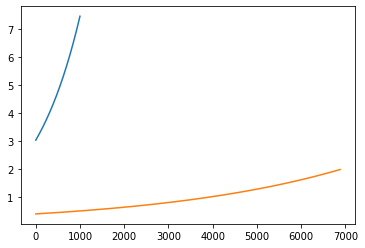

In [199]:
plt.plot(np.diff(new_wl))
plt.plot(np.diff(10**(min_wl+np.arange(npix_max)*1e-4)))

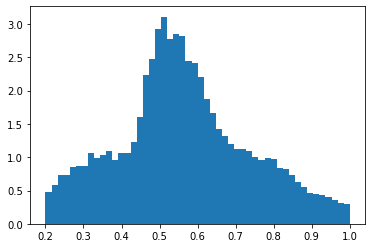

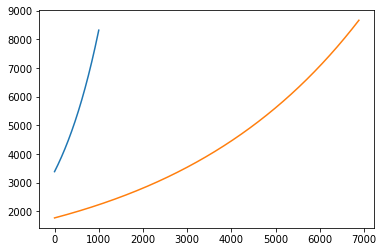

In [200]:
_ = plt.hist(redshifts, bins=50,density=True)
plt.show()

plt.plot((new_wl))
plt.plot((10**(min_wl+np.arange(npix_max)*1e-4)))
plt.show()

In [201]:
from scipy.stats import binned_statistic

In [202]:
raw_flux           = []
raw_noise          = []
raw_masks          = []

res_fluxes         = []
res_inv_vars       = []
res_masks          = []
redshifts          = []

SNs                = []

flag               = []

ii=0

for nn, image in enumerate(tfds.as_numpy(ds)):
        
    # compute wavelengths
    log10wl  = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
    log10wl  = log10wl
    wl       = 10**log10wl
    
    raw_flux.append(image['flux'])
    raw_noise.append(image['inv_var'])
    raw_masks.append(image['and_mask'])
    ##rescale flux by wavelength and distance
    factor   = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
    #flux
    
    ### change that to before de-redshifting
    flux     = image['flux'][:,0]*factor*wl
    #inv_var
    inv_var  = image['inv_var'][:,0]/(wl*factor)**2
    
    wl/=(1.+image['redshift'])
    
    ## mask
    
    #mask
    mask           = np.squeeze(image['and_mask'])
    #mask pixels that are completely noise dominated (mask!)
    noise_         = np.squeeze(inv_var)
    ind            = np.where(noise_==0.)
    mask[ind]      = False 
    # additional mask on skylines
#     lines_wl       = (5565,5590)/(1+image['redshift'])
#     lines_ind      = np.digitize([lines_wl[0],lines_wl[1]],wl)
#     lines_ind      = np.arange(lines_ind[0],lines_ind[1])
#     mask[lines_ind]= False
    mask_ind = np.where(mask)

    if len(mask_ind[0])==0:
        continue
    ##resample
    #flux
    else:
        res_flux, _, _ = binned_statistic(wl[mask_ind], flux[mask_ind],bins=new_wl)
        

        #inv_var
#         interval       = np.digitize((new_wl[0],new_wl[-1]),wl)
#         #print(wl[interval[0]:interval[1]],new_wl[0],new_wl[-1])
#         N              = np.digitize(new_wl, wl[interval[0]:interval[1]])
#         N              = np.diff(N)
#         #make sure N=0 is only outside of boundaries where everything is set to zero anyways
#         assert(np.all(np.logical_or(new_wl[np.where(N==0)]<min(wl),new_wl[np.where(N==0)]>max(wl))))
#         N[np.where(N==0)]=1
#         N              = np.append(N,1)

    #     plt.figure()
    #     plt.plot(wl,noise_)
    #     plt.plot(wl[mask_ind],noise_[mask_ind])
    #     #plt.ylim(0,1)
    #     plt.show()


        noise          = 1./noise_[mask_ind]
        noise_, _, _   = binned_statistic(wl[mask_ind],noise,bins=new_wl)
        N, _, _        = binned_statistic(wl[mask_ind],values=np.zeros(len(wl[mask_ind])),statistic='count',bins=new_wl)
        new_mask_ind   = np.where(N==0)
        noise_          = noise_/N
        inv_var_res    = 1./noise_
        res_flux[new_mask_ind] = 0
        res_fluxes.append(res_flux)
    
#         #mask
#         # conservative
#         mask[np.where(wl<min(new_wl))]=0
#         mask[np.where(wl>max(new_wl))]=0


#         mask_ind      = np.unique(np.digitize(wl[interval[0]:interval[1]][np.where(np.logical_not(mask[interval[0]:interval[1]]))],new_wl))
#         #print(mask_ind)
        new_mask_cons = np.ones(len(new_wl)-1)
        new_mask_cons[new_mask_ind] = 0.
#         # set mask to zero outside of wl boundaries
#         new_mask_cons[np.where(new_wl<min(wl))]=0
#         new_mask_cons[np.where(new_wl>max(wl))]=0

# #         plt.plot(wl,mask)
# #         plt.plot(new_wl,new_mask_cons)
# #         plt.xlim(5000,5100)
# #         plt.show()

#         #flag is a good flag
            
        res_masks.append(new_mask_cons)
# len(np.where(new_mask_cons==0)[0])<fixed_num_bins*0.8 and 

        SN = np.sum(res_flux)/np.sqrt(np.sum(1./inv_var_res))
        SNs.append(SN)
        
        inv_var_res[new_mask_ind] = 0
        res_inv_vars.append(inv_var_res)
    
        if SN<50:
            flag.append(ii)

        redshifts.append(image['redshift'])
        ii+=1

0.5633658
1000
(array([], dtype=int64),)


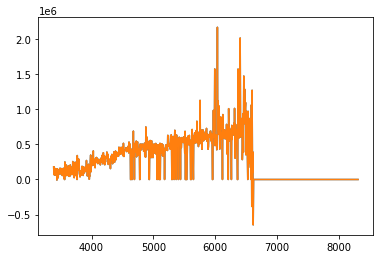

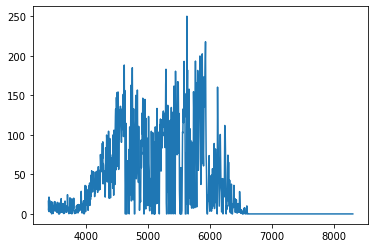

0.7287239
1000
(array([], dtype=int64),)


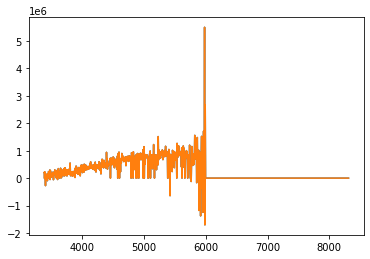

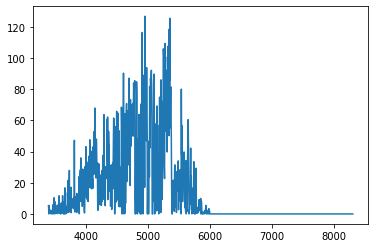

0.80304116
1000
(array([], dtype=int64),)


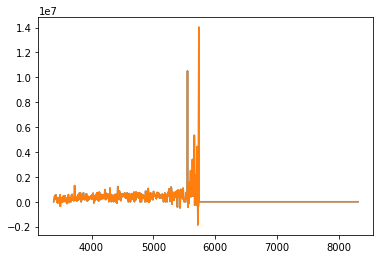

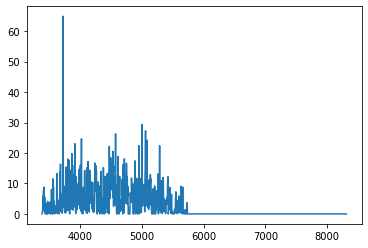

0.57095224
1000
(array([], dtype=int64),)


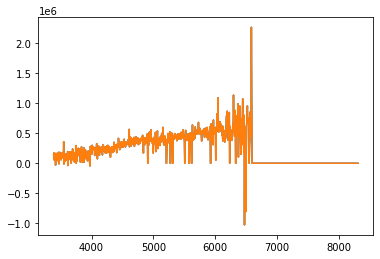

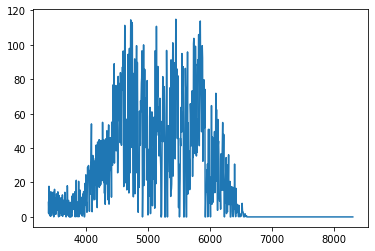

0.53570426
1000
(array([], dtype=int64),)


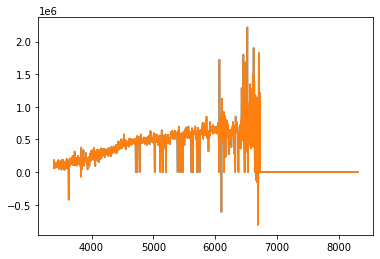

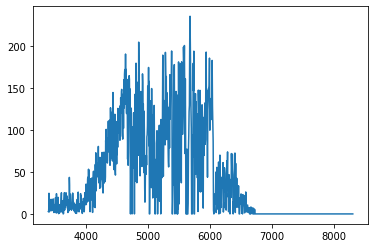

0.36672553
1000
(array([], dtype=int64),)


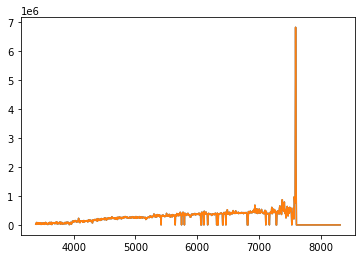

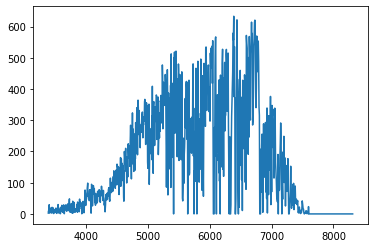

0.7391062
1000
(array([], dtype=int64),)


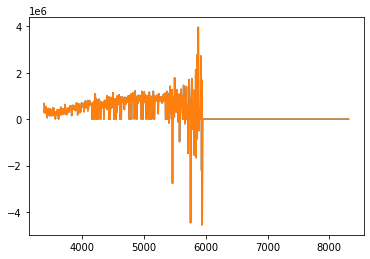

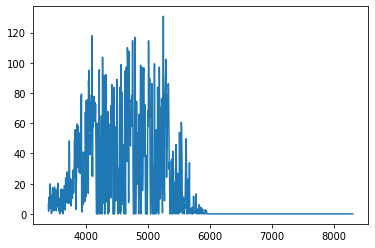

0.53251487
1000
(array([], dtype=int64),)


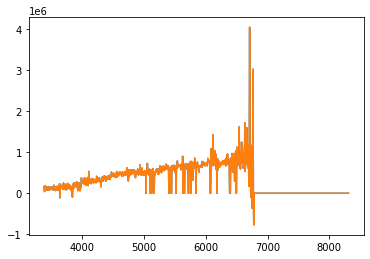

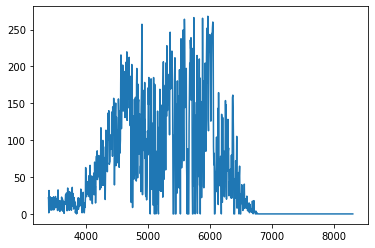

0.3344715
1000
(array([], dtype=int64),)


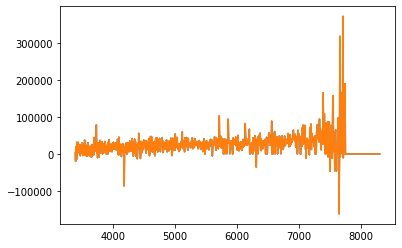

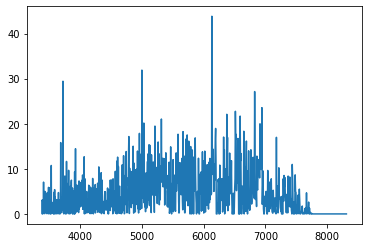

0.768068
1000
(array([], dtype=int64),)


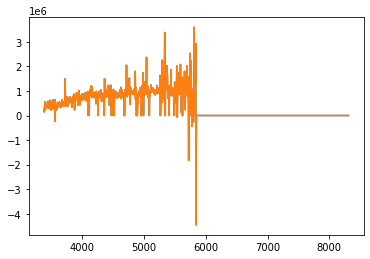

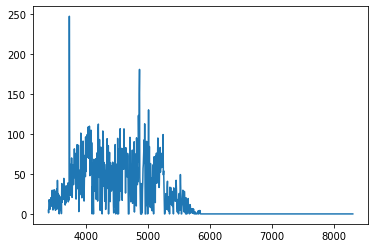

0.658559
1000
(array([], dtype=int64),)


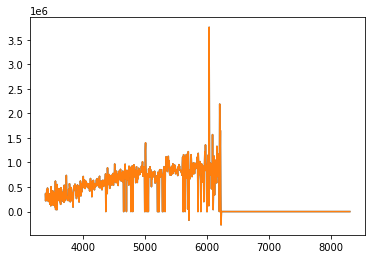

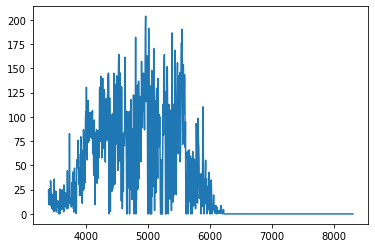

0.63136345
1000
(array([], dtype=int64),)


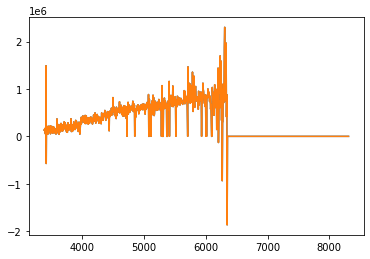

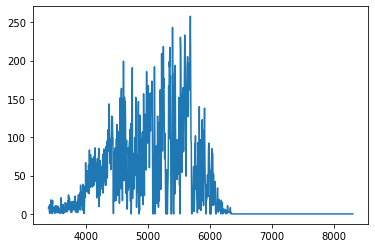

0.39055544
1000
(array([], dtype=int64),)


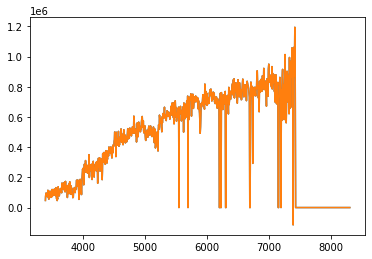

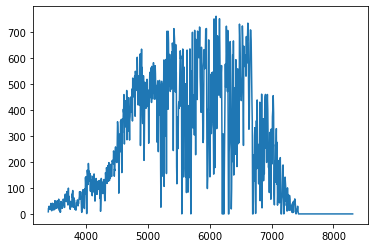

0.5253741
1000
(array([], dtype=int64),)


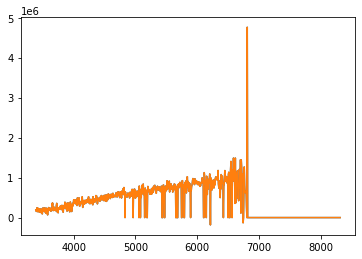

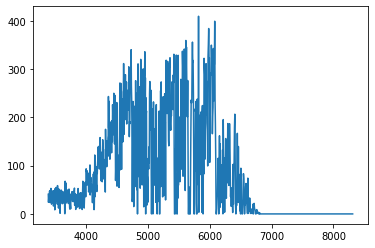

0.87322783
1000
(array([], dtype=int64),)


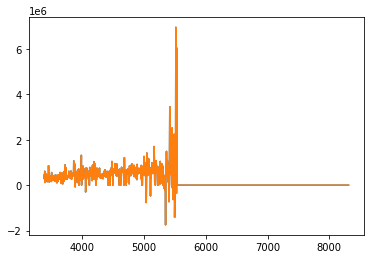

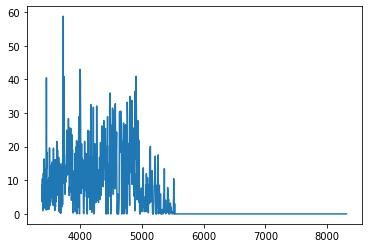

0.40344292
1000
(array([], dtype=int64),)


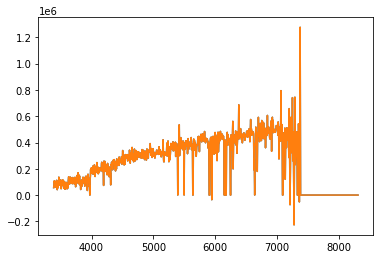

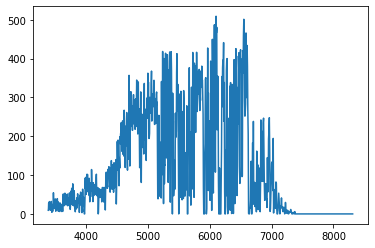

0.73248744
1000
(array([], dtype=int64),)


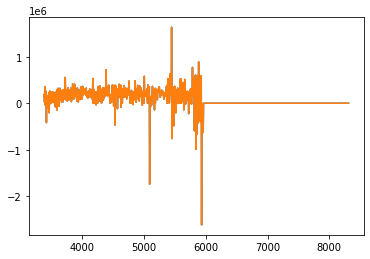

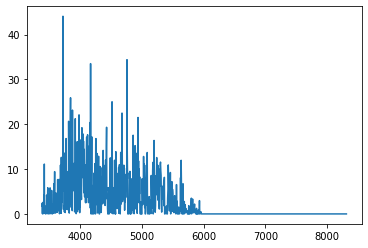

0.4499132
1000
(array([], dtype=int64),)


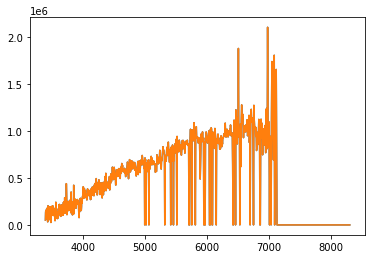

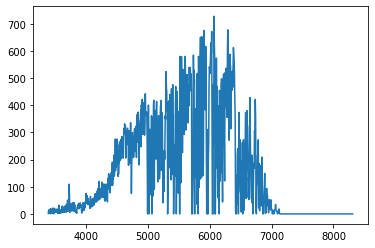

0.29741713
1000
(array([], dtype=int64),)


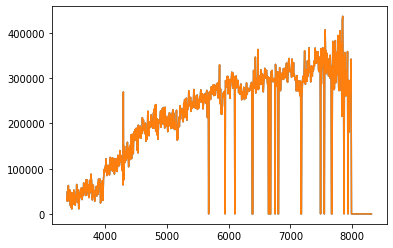

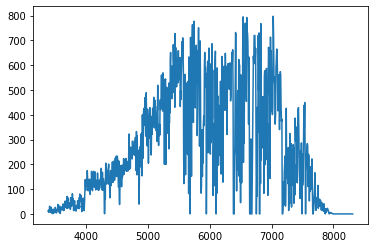

0.25946042
1000
(array([], dtype=int64),)


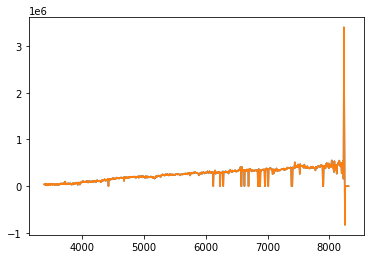

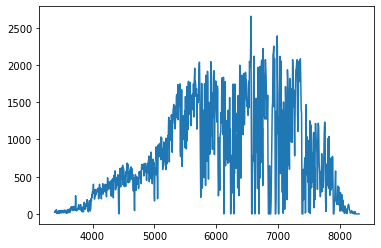

0.5580622
1000
(array([], dtype=int64),)


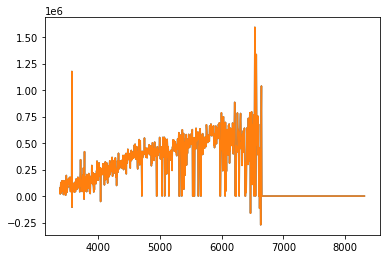

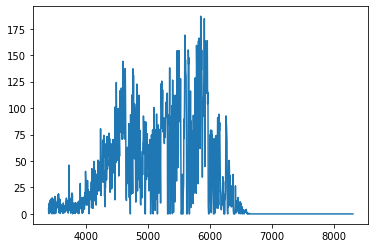

0.5814564
1000
(array([], dtype=int64),)


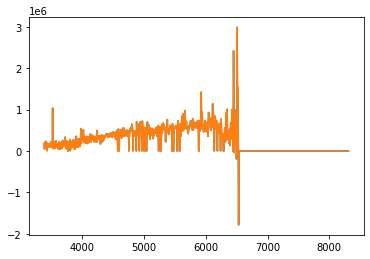

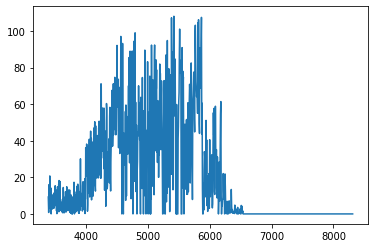

0.57628983
1000
(array([], dtype=int64),)


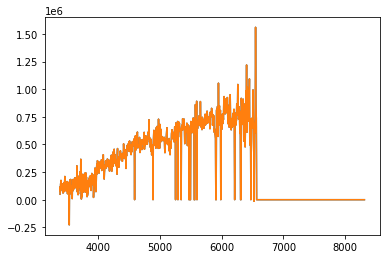

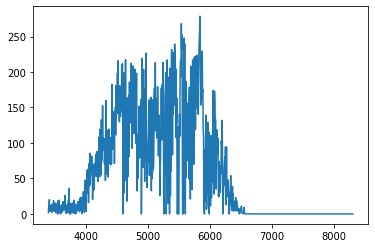

0.52404505
1000
(array([], dtype=int64),)


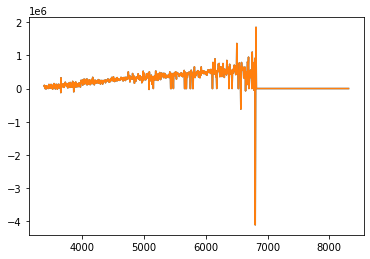

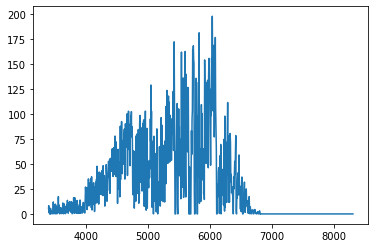

0.71960783
1000
(array([], dtype=int64),)


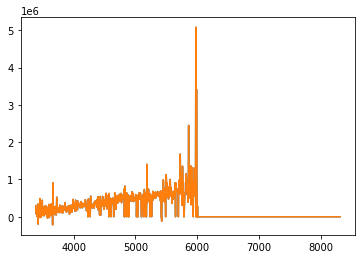

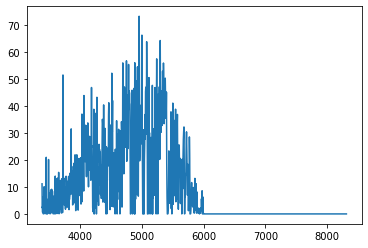

0.42661768
1000
(array([], dtype=int64),)


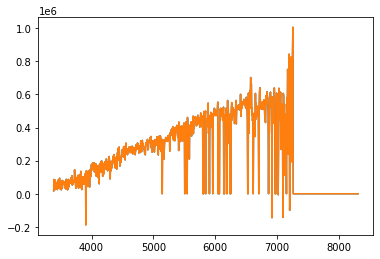

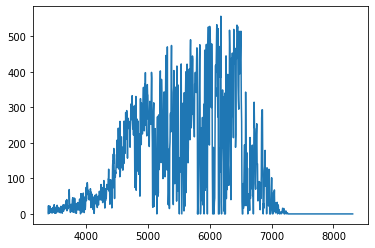

0.33555654
1000
(array([], dtype=int64),)


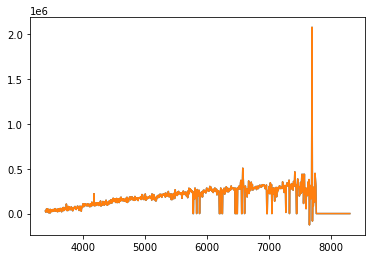

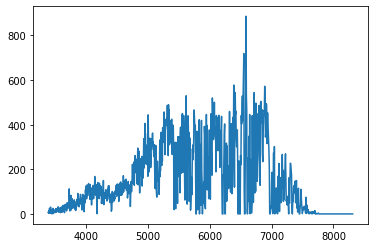

0.5757757
1000
(array([], dtype=int64),)


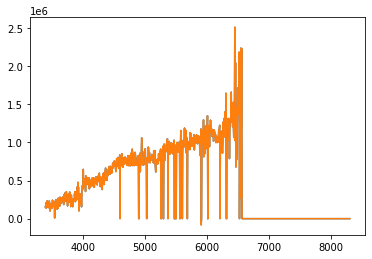

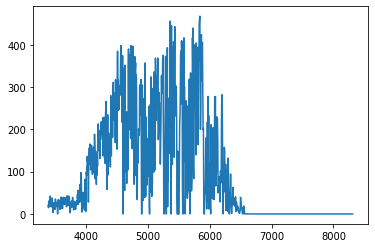

0.50305295
1000
(array([], dtype=int64),)


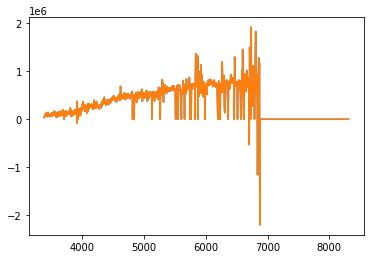

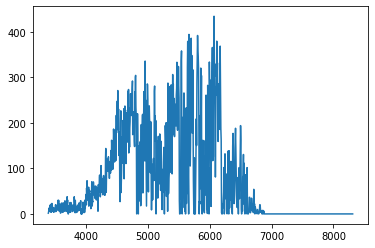

0.6789606
1000
(array([], dtype=int64),)


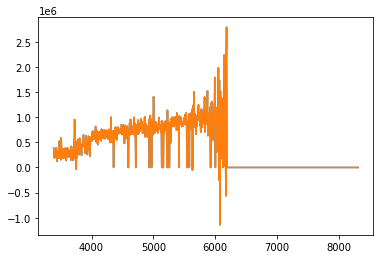

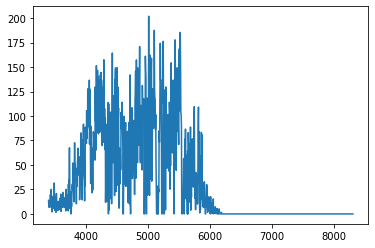

In [204]:
for ii in range(30):
#     if ii in flag:
    print(redshifts[ii])
    #plt.plot(np.arange(1000),new_fluxes[ii])
    print(len(res_fluxes[ii]))
    plt.errorbar(new_wl[:-1],res_fluxes[ii])#,yerr=np.sqrt(1./res_inv_vars[ii])*res_masks[ii],ecolor='red')
    print(np.where(np.isnan(res_fluxes[ii])))
#     print(np.where(res_masks[ii]==0))
    plt.errorbar(new_wl[:-1],res_fluxes[ii]*res_masks[ii])
    #plt.ylim(-0.5,.5)
    plt.show()
    plt.errorbar(new_wl[:-1],res_fluxes[ii]**2*res_inv_vars[ii]*res_masks[ii])
    #plt.ylim(-0.5,.5)
    plt.show()

In [206]:
#_ = plt.hist((np.asarray(SNs)),density=True, bins=500)

In [207]:
# new_fluxes         = []
# new_fluxes_detrend = []
# noises             = []
# noises_detrend     = []
# masks              = []
# params             = []
# redshifts          = []
# SN                 = []



# rescale = 6e6

# for nn, image in enumerate(tfds.as_numpy(ds)):
        
#     # compute wavelengths
#     log10wl  = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])-np.log10(1+image['redshift'])
#     log10wl  = log10wl
#     wl       = 10**log10wl

#     # rescale flux by wavelength and distance
#     factor   = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
    
    
#     raw_flux.append(image['flux'])
#     raw_noise.append(image['inv_var'])
#     raw_masks.append(image['and_mask'])
    
#     # mask some atmospheric lines
#     lines_wl       = (5500,5600)/(1+image['redshift'])
#     lines_ind      = np.digitize([lines_wl[0],lines_wl[1]],wl)
#     lines_ind      = np.arange(lines_ind[0],lines_ind[1])
    
#     ### mask and rescale
#     mask           = np.squeeze(image['and_mask'])
#     mask2          = np.ones(mask.shape)
#     mask2[lines_ind]= 0.
#     flux           = flux*(mask*mask2)
    
#     flux           = flux/rescale
    
#     ### resample flux
#     interp   = interp1d(x=wl,y=flux,bounds_error=False, fill_value=0.,kind='linear')
#     new_flux = interp(new_wl)
#     new_fluxes.append(new_flux)
    
#     ### deterend flux
#     kernel_size    = 10
#     kernel         = np.ones(kernel_size) / kernel_size
#     data_convolved = np.convolve(new_flux, kernel, mode='same')
    
#     interp         = interp1d(x=new_wl,y=data_convolved,bounds_error=False, fill_value=0.,kind='linear')
#     x1_,x2_,x3_    = wl[0]+250, (wl[-1]+wl[0])/2, wl[-1]-250
#     x1,x2,x3       = np.digitize([x1_,x2_,x3_],new_wl)
#     y1, y2, y3     = interp([x1_,x2_,x3_])
#     a              = (x1*(y3-y2)+x2*(y1-y3)+x3*(y2-y1))/((x1-x2)*(x1-x3)*(x2-x3))
#     b              = ((y2-y1)-a*(x2**2+x1**2))/(x2-x1)
#     c              = y1-a*x1**2-b*x1
#     begin,end      = np.digitize([wl[0],wl[-1]],new_wl)
#     trend          = a*np.arange(begin,end)**2+b*np.arange(begin,end)+c
#     trend[trend==0]= 1
#     trend          = np.concatenate((np.ones((begin)),trend,np.ones((fixed_num_bins-end))))
#     new_flux       = new_flux/trend
#     new_fluxes_detrend.append(new_flux)
    
#     # parameters are either detrending parameters or redshifts
#     params.append([a,b,c,image['redshift']])
#     redshifts.append(image['redshift'])
    
#     ### noise (with same transformations as flux)
#     N              = np.diff(np.digitize(new_wl, wl))
#     N[np.where(N==0)] = 1
#     N              = np.append(N,1)
#     noise_         = np.squeeze(image['inv_var'])
#     noise_         = noise_*mask
#     ind            = np.where(noise_!=0)
#     noise          = np.zeros(noise_.shape, dtype=np.float32)
#     noise[ind]     = np.sqrt(1./noise_[ind])*wl[ind]*factor/rescale
#     interp         = interp1d(x=wl,y=noise**2,bounds_error=False, fill_value=0.,kind='linear')
#     noise          = np.zeros(new_wl.shape)
#     noise_         = interp(new_wl)/N
#     ind            = np.where(noise_!=0)
#     noise[ind]     = 1./noise_[ind]
#     noises.append(noise)
#     noise          = np.zeros(new_wl.shape)
#     noise_         = noise_/trend**2
#     ind            = np.where(noise_!=0)
#     noise[ind]     = 1./noise_[ind]
#     noises_detrend.append(noise)

#     # interpolate mask
#     interp         = interp1d(x=wl,y=mask,bounds_error=False, fill_value=0.)
#     mask           = interp(new_wl)
#     mask[0:120]    = 0.
#     masks.append(mask)
    
#     SN.append(np.mean(new_fluxes[-1]**2*noises[-1]*masks[-1]))
    

In [208]:
#! pip install sklearn

In [209]:
import sklearn

In [210]:
from sklearn.decomposition import PCA

In [213]:
pca       = PCA(n_components=200)
pca.fit(np.asarray(res_fluxes)[:100000])

variances = pca.explained_variance_ratio_


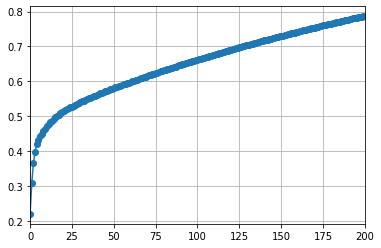

In [214]:
plt.plot(np.cumsum(variances),marker='o')
plt.xlim(-0.01,200)
plt.grid()

In [215]:
enc   = pca.transform(res_fluxes)
recon = pca.inverse_transform(enc)

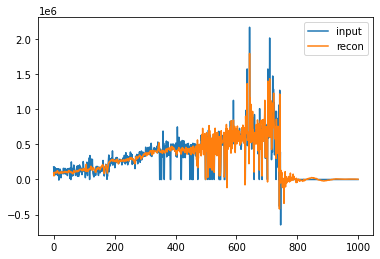

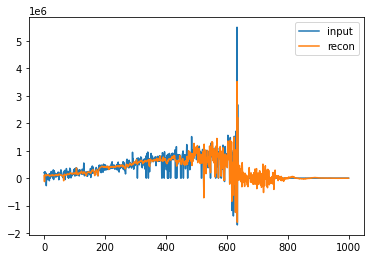

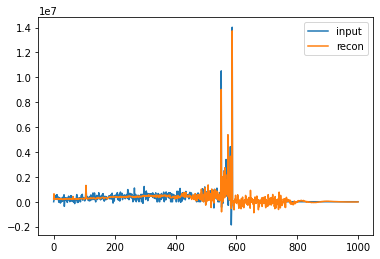

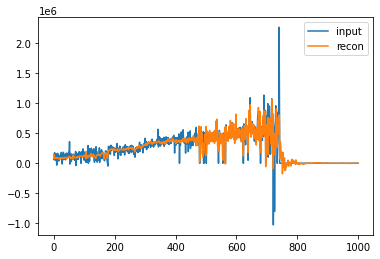

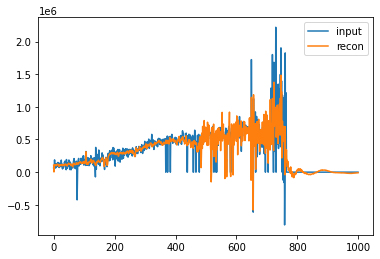

In [217]:
for ii in range(5):
    plt.plot(np.asarray(res_fluxes)[ii], label= 'input')
    plt.plot(recon[ii],label='recon')
    plt.legend()
    plt.show()

In [332]:
latent_dim = 40
dim        = fixed_num_bins

In [333]:
network_type='fully_connected'

In [334]:
from tensorflow.keras.layers import concatenate as concat

In [335]:
class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM1  = LSTM(units[0],  return_sequences=True)
        self.LSTM2  = LSTM(units[1],  return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM2(self.LSTM1(inputs)))

    def compute_mask(self, inputs, mask=None):
        return mask


input        = Input(shape=(dim,1))
input_params = Input(shape=(1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))


if network_type=='fully_connected':
# simplest, not many architectural choices other than number of neurons, likely to overfit
    #encoder_input = input#tf.concat([input,tf.tile(input_z,[tf.shape(input)[0],1])], axis=1)
#    x = Reshape((dim,))(input)
#    x = tf.concat([input,input_params],axis=1)
    x = Flatten()(input)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(latent_dim)(x)  
    #x = tf.concat([x,input_params],axis=1)
    #z = Flatten()(input_params)
    #x = tf.concat([input_params,x], axis=1)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Dense(dim)(x)
    x = Reshape((dim,1))(x)
elif network_type=='LSTM':
# slow training
    x = LSTM(256, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(latent_dim,  return_sequences=False, name='bottleneck')(x)
    x = RepeatVector(dim)(x)
    x = LSTM(latent_dim, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(256, return_sequences=True)(x)
    x = TimeDistributed(Dense(1))(x)
elif network_type=='CNN':
# better than fully connected, but more choices to make for architecture, performance might be very much dependent on architecture
    x = Conv1D(filters=64,kernel_size=(5), strides=2, name='conv1', padding='same')(input)
    x = BatchNormalization(name='bn1')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2, name='maxpool1', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2,name='conv2', padding='same')(x)
    x = BatchNormalization(name='bn2')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2,name='maxpool2', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2, name='conv3', padding='same')(x)
    x = BatchNormalization(name='bn3')(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    #x = tf.concat([y,input_params],axis=1)
    x = Dense(latent_dim, name='fc_enc')(x)
    x = LeakyReLU()(x)
    #x = tf.concat([z,input_params], axis=1)
    x = Dense(1024,name='fc_dec')(x)
    x = LeakyReLU()(x)
    x = Reshape((32,32))(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv1T', padding='same')
    x = BatchNormalization(name='bn1T')(x)
    x = LeakyReLU()(x)
    #x = UpSampling1D(2, name='up1')(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv2T', padding='same')
    x = BatchNormalization(name='bn2T')(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2,name='up2')(x)
    x = Conv1DTranspose(input_tensor=x,filters=64,kernel_size=(5),strides=2, name='conv3T', padding='same')
    x = BatchNormalization(name='bn3T')(x)
    x = LeakyReLU()(x)
    x = Conv1DTranspose(input_tensor=x,filters=1,kernel_size=(1),strides=1, padding='same')
#    x = Reshape((dim,1))(x)
else:
    raise ValueError('Network type not supported')

def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = (tf.reduce_mean(loss*mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(input_data[0], training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}



def custom_metric(y_true, y_pred):
    loss = tf.math.square(y_true[0]-y_pred)*y_true[3]
    valid_loss = tf.reduce_mean(loss*tf.boolean_mask(loss,y_true[2]))
    return valid_loss
    
    
    
lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_params], outputs=x)
lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), my_loss=lossFunction, metrics=['mse'],run_eagerly=False)

# lstm_ae = Model(inputs=[input, input1,input2, input_float], outputs=[x, input1,input2, input_float])
# lstm_ae.compile(optimizer='adam', loss=lossFunction)
print(lstm_ae.summary())

Model: "custom_model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_121 (InputLayer)          [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten_20 (Flatten)            (None, 1000)         0           input_121[0][0]                  
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 512)          512512      flatten_20[0][0]                 
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 512)          2048        dense_43[0][0]                   
____________________________________________________________________________________

In [306]:
# for i, l in enumerate(lstm_ae.layers):
#     print(f'layer {i}: {l}')
#     print(f'has input mask: {l.input_mask}')
#     print(f'has output mask: {l.output_mask}')

In [311]:
BATCH_SIZE   = 32

train_size   = int(0.6 * DATASET_SIZE)
test_size    = int(0.2 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)

# train_dataset = prep_data.take(train_size).repeat().map(lambda x: ((x['flux'],x['detrend'], x['mask'], x['inverse']),x['flux'])).batch(BATCH_SIZE)
# test_dataset  = prep_data.skip(train_size).take(test_size).map(lambda x: ((x['flux'],x['detrend'], x['mask'], x['inverse']),(x['flux'], x['mask'], x['inverse']))).batch(BATCH_SIZE)
# valid_dataset = prep_data.skip(train_size+test_size).take(valid_size).map(lambda x:((x['flux'],x['detrend'], x['mask'], x['inverse']),(x['flux'], x['mask'], x['inverse']))).batch(BATCH_SIZE)


In [308]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.5)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [309]:
train_data   = np.expand_dims(np.asarray(res_fluxes)[:train_size],-1)#/np.std(np.asarray(res_fluxes)[:60000],axis=0)
valid_data   = np.expand_dims(np.asarray(res_fluxes)[train_size:train_size+valid_size],-1)#/np.std(np.asarray(res_fluxes)[60000:],axis=0)
train_mask   = np.expand_dims(np.asarray(res_masks)[:train_size],-1)
valid_mask   = np.expand_dims(np.asarray(res_masks)[train_size:train_size+valid_size],-1)
train_noise  = np.expand_dims(np.asarray(res_inv_vars)[:train_size],-1)
valid_noise  = np.expand_dims(np.asarray(res_inv_vars)[train_size:train_size+valid_size],-1)
train_params = np.asarray(redshifts)[:train_size]
valid_params = np.asarray(redshifts)[train_size:train_size+valid_size]

In [312]:
history = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_params), y=None, batch_size=BATCH_SIZE, epochs=40, callbacks=[callback])

Epoch 1/40
 144/1944 [=>............................] - ETA: 5:02 - training_loss: 101.1122

KeyboardInterrupt: 

In [286]:
history.history['training_loss']

[1.7704195976257324,
 1.4241242408752441,
 1.5188533067703247,
 2.0721070766448975,
 1.7588244676589966,
 1.5996618270874023,
 1.8166824579238892,
 1.9381473064422607,
 1.4081209897994995,
 1.4111994504928589,
 1.444292426109314,
 1.6110055446624756,
 1.4251142740249634,
 1.8108649253845215,
 1.4568787813186646,
 1.6531970500946045,
 2.329824209213257,
 1.5409773588180542,
 1.964577555656433,
 1.3178070783615112,
 1.635368824005127,
 1.4771901369094849,
 1.5087950229644775,
 2.27691650390625,
 1.5035954713821411,
 2.05483078956604,
 1.7387957572937012,
 1.458526849746704,
 1.4904937744140625,
 1.710099220275879,
 2.8438310623168945,
 1.51577889919281,
 1.7615829706192017,
 1.6575194597244263,
 1.5942386388778687,
 1.5924890041351318,
 1.7188570499420166,
 1.8977782726287842,
 1.6257405281066895,
 1.5332058668136597]

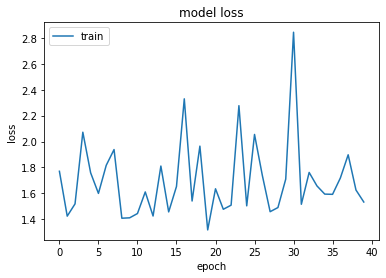

In [287]:
plt.plot(history.history['training_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [288]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(curr_layer)
        new_model.add(curr_layer)
    return new_model

In [289]:
encoder = extract_layers(lstm_ae,1,14)

decoder = extract_layers(lstm_ae,14,26)

In [290]:
encoder.build((None,fixed_num_bins))
decoder.build((None,latent_dim))

In [291]:
encoder.summary()
decoder.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               512512    
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               2048      
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)             

In [292]:
encoded = encoder.predict(valid_data)

In [293]:
decoded = decoder.predict(encoded)

In [294]:
encoded

array([[-1.4705416 , -0.46821108, -1.76012   , ..., -0.9423004 ,
        -5.8256516 , -6.3984227 ],
       [ 0.1292741 ,  0.29192758, -1.1423074 , ..., -1.4790026 ,
         0.88704455,  0.696924  ],
       [ 1.3101054 , -0.01797664, -1.8854557 , ..., -1.144412  ,
         1.9828434 ,  1.4843395 ],
       ...,
       [-0.10718993, -0.09127248, -0.7456263 , ..., -0.6154409 ,
         0.6459883 ,  0.74882346],
       [ 0.9396444 , -0.4726864 , -0.95786315, ...,  0.09017912,
         2.7538264 ,  2.534207  ],
       [ 0.20256636,  0.07930306, -0.9774669 , ..., -0.7707316 ,
         1.0085825 ,  0.8373427 ]], dtype=float32)

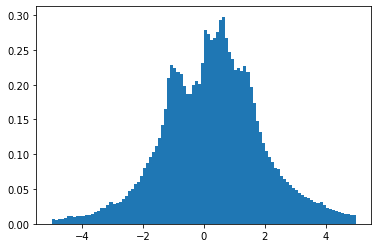

In [295]:
_=plt.hist(encoded.flatten(),bins=100,density=True, range=(-5,5))

In [296]:
recon_train   = decoded


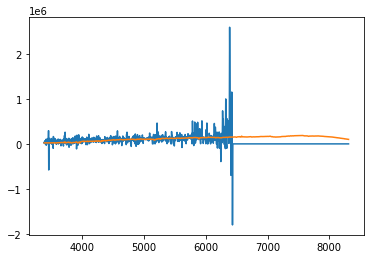

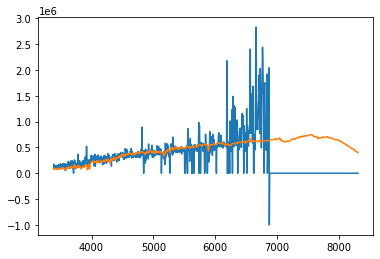

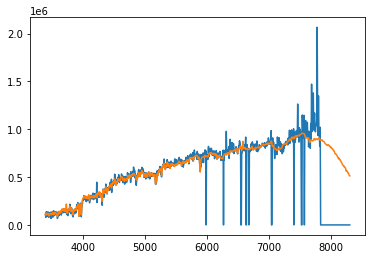

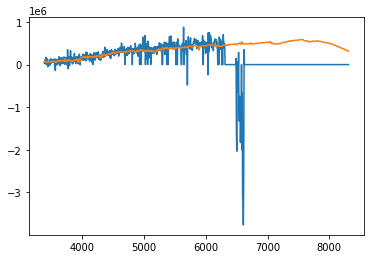

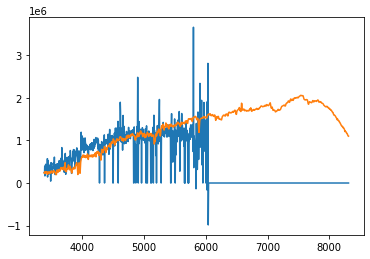

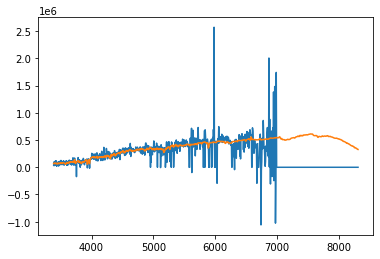

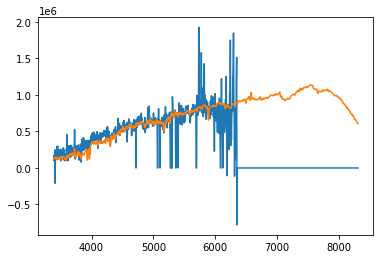

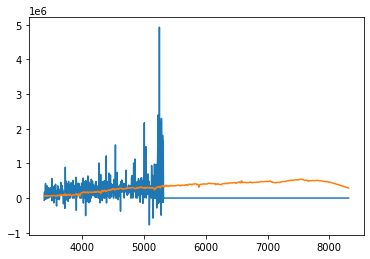

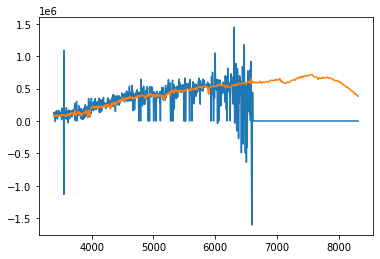

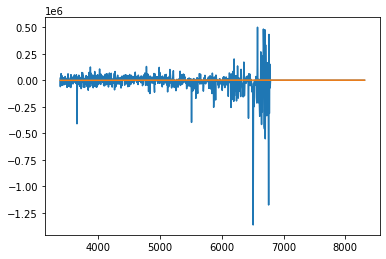

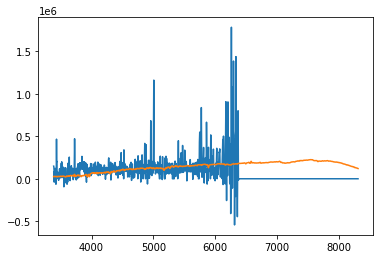

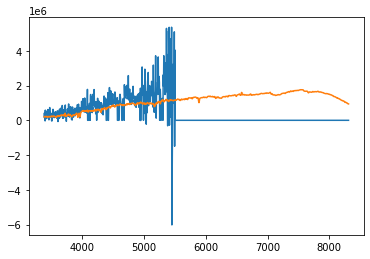

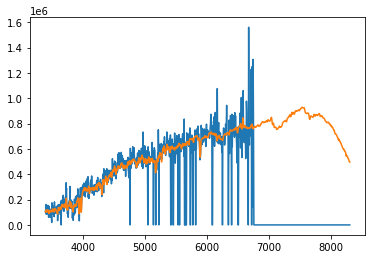

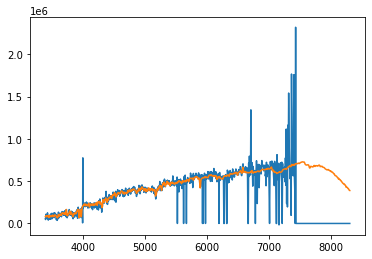

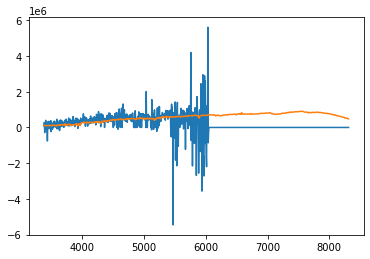

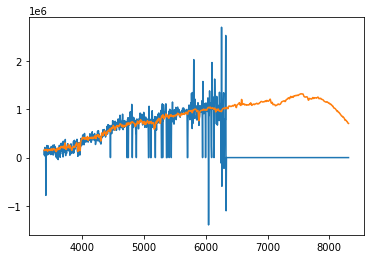

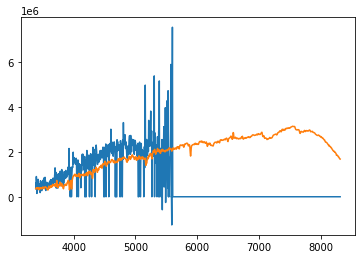

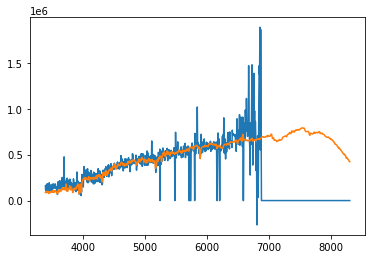

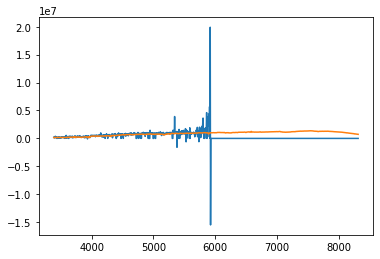

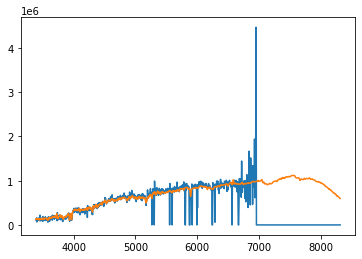

In [297]:
for ii in range(20):
    plt.plot(new_wl[:-1], valid_data[ii])
    plt.plot(new_wl[:-1], recon_train[ii])
    plt.show()

In [ ]:
# encoded.shape

In [ ]:
# decoder = extract_layers(lstm_ae, 18, -1)
# print(encoded.shape)

In [ ]:
# decoder.predict(encoded).shape

In [ ]:
    
plt.plot(np.mean((train_data[:512]-np.squeeze(recon_train[:512]))**2,axis=0))

In [ ]:
plt.plot(np.std((valid_data[:512]-np.squeeze(recon_train[:512]))**2*np.squeeze(valid_noise)[:512]*np.asarray(masks)[:512],axis=0))

In [ ]:
plt.plot(np.std(np.squeeze(recon_train[:512])*np.asarray(masks)[:512],axis=0))

In [ ]:
plt.plot(np.std(np.squeeze(data[:512])*np.asarray(masks)[:512],axis=0))

In [ ]:

for ii in range(20):
    plt.plot(new_wl,data[ii]*masks[ii],label='noisy,masked truth')
    #errs = np.zeros(npix_max, np.int32)
    #errs[np.where(train[0][2][ii].numpy()!=0)[0]] = np.sqrt(1./(train[0][2][ii].numpy()[np.where(train[0][2][ii].numpy()!=0)]))
    plt.errorbar(new_wl,recon_train[ii]*masks[ii])#,yerr=np.squeeze(np.sqrt(1/train[0][3][ii])),label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
    plt.ylim(-0.1,0.1)
    #plt.xlim(4000,5000)
    plt.legend()
    plt.show()
#     plt.plot(np.arange(dim)[600:700],train[0][0][ii][600:700],label='noisy,masked truth')
#     plt.errorbar(np.arange(dim)[600:700],recon_train[ii][600:700],label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
#     plt.legend()
#     plt.show()

for ii in range(20):
    plt.plot(new_wl,(data[ii]-recon_train[ii])**2*noise_train[ii]*masks[ii])
    #errs = np.zeros(npix_max, np.int32)
    #errs[np.where(train[0][2][ii].numpy()!=0)[0]] = np.sqrt(1./(train[0][2][ii].numpy()[np.where(train[0][2][ii].numpy()!=0)]))
    #plt.errorbar(new_wl,*masks[ii])#,yerr=np.squeeze(np.sqrt(1/train[0][3][ii])),label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
    #plt.ylim(-0.1,0.1)
    #plt.xlim(4000,5000)
    plt.legend()
    plt.show()


In [ ]:
for test in test_dataset.take(1):
    for ii in range(20):
        plt.plot(test[0][0][ii],label='noisy,masked truth')
        errs = np.squeeze(np.sqrt(1/test[0][3][ii]))
        print(recon_test[ii].shape, errs.shape)
        plt.errorbar(np.arange(dim),np.squeeze(recon_test[ii]),yerr=errs,label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
        plt.legend()
        plt.show()